# Adaptive Component Separation with K-means Clustering

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CMBSciPol/furax-compsep-paper/blob/main/notebooks/kmeans_2.ipynb)

## Learning Objectives

By the end of this notebook, you will:
- Understand adaptive sky clustering for spatially-varying spectral parameters
- Implement spherical K-means clustering for CMB component separation
- Optimize parameters within each cluster using variance-based selection
- Visualize how spatial parameter variation improves foreground modeling

## The Adaptive Clustering Approach

Traditional component separation assumes uniform spectral parameters across the entire sky. In reality, Galactic emissions vary spatially. Our approach uses spherical K-means clustering to partition the sky into regions, allowing different spectral parameters in each cluster.

**Key Innovation**: Minimize CMB reconstruction variance by adaptively clustering sky pixels and optimizing spectral parameters per cluster.

## Import Required Libraries and Configure Environment

Before we begin, we need to import the necessary libraries and configure the computational environment:

- **FURAX Framework**: Modern JAX-based component separation tools including operators for CMB, dust, and synchrotron
- **JAX-HEALPix**: Clustering utilities for spherical K-means and mask operations
- **JAX Configuration**: Enable 64-bit precision for scientific accuracy
- **Environment Setup**: Configure CPU mode and NaN error handling for debugging

The clustering approach requires specialized tools for working with spherical data, which JAX-HEALPix provides through efficient implementations of K-means clustering on the sphere.

## Load and Prepare Multi-Frequency Sky Data

We now load the simulated CMB and foreground observations that will be used for component separation:

### Data Parameters

- **NSIDE = 64**: HEALPix resolution parameter (49,152 pixels, ~55 arcmin resolution)
- **Sky Model**: c1d1s1 (CMB + dust + synchrotron emission)
- **Frequency Coverage**: 15 bands from 40 to 402 GHz (LiteBIRD configuration)
- **Polarization**: Q and U Stokes parameters (we focus on polarization for B-mode analysis)

### Sky Masking

We use the **GAL020 mask** which retains the cleanest 20% of the sky, avoiding regions of strong galactic emission. This is crucial because:
- Galactic foregrounds are strongest near the plane
- Component separation is most accurate in low-foreground regions
- CMB B-mode measurements require the cleanest possible data

The masked data extraction reduces computational cost by only analyzing pixels where we expect reliable results.

## Generate Spherical K-Means Clusters for Spectral Parameters

The key innovation of this approach is using **adaptive clustering** to capture spatial variations in spectral parameters. Different astrophysical parameters vary at different spatial scales:

### Cluster Configuration Strategy

We assign different cluster counts based on expected spatial variation:

- **Dust Temperature** (100 clusters): Varies relatively smoothly across the sky, following large-scale galactic structure
- **Dust Spectral Index β_dust** (2000 clusters): Shows more rapid spatial variation due to changes in grain composition and size distribution
- **Synchrotron Spectral Index β_sync** (100 clusters): Varies smoothly, following large-scale magnetic field and cosmic ray distributions

### Spherical K-Means on the Sky

Traditional K-means assumes Euclidean geometry, but the sky is a sphere. We use **spherical K-means** which:
- Respects the spherical geometry of HEALPix maps
- Clusters pixels based on angular proximity
- Normalizes cluster indices for efficient indexing

This clustering strategy allows each region of the sky to have its own set of spectral parameters, dramatically improving foreground modeling compared to uniform parameter methods.

## Optimize Spectral Parameters Using L-BFGS

With clusters defined, we now optimize spectral parameters to minimize the CMB reconstruction variance. This is a **likelihood-based optimization** where each cluster gets its own parameter values.

### Reference Frequencies

Component separation requires reference frequencies where template maps are defined:
- **Dust reference**: 150 GHz (near the peak of dust spectral energy distribution)
- **Synchrotron reference**: 20 GHz (low frequency where synchrotron dominates)

### Cluster-Specific Parameters

Instead of fitting a single global parameter value, we optimize:
- 100 dust temperature values (one per dust cluster)
- 2000 dust spectral index values (one per beta_dust cluster)
- 100 synchrotron spectral index values (one per sync cluster)

This dramatically increases the model flexibility and captures spatial variations in foreground properties.

### L-BFGS Optimization

We use the **L-BFGS** (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) algorithm because:
- It uses gradient information (automatic differentiation via JAX)
- It approximates second-order curvature information for fast convergence
- It has limited memory requirements despite high dimensionality
- It naturally handles the smooth likelihood surfaces typical of CMB analysis

The optimization minimizes the negative log-likelihood, with convergence tolerance set to 1e-6.

## Reconstruct Full-Sky Parameter Maps from Cluster Values

After optimization, each cluster has an optimized parameter value. We now map these cluster-level parameters back to full HEALPix maps for visualization and scientific interpretation.

### Mapping Process

For each spectral parameter:
1. **Retrieve optimized values**: Get the parameter array (e.g., 2000 values for beta_dust)
2. **Apply cluster assignments**: Map each pixel to its cluster's parameter value using the cluster indices
3. **Reconstruct full sky**: Use `get_fullmap_from_cutout` to convert masked pixels back to full HEALPix format

This process creates spatially-varying parameter maps where:
- Each pixel within a cluster shares the same parameter value
- Different clusters have different parameter values
- The result is a piecewise-constant map capturing spatial variations

We also reconstruct the CMB Q and U maps, which represent the separated CMB polarization signal after foreground removal.

## Visualize Optimized Spectral Parameter Maps

The final parameter maps reveal the spatial structure of galactic foreground properties across the sky. Understanding these patterns is crucial for assessing the quality of component separation.

### What Each Map Shows

- **Dust Temperature**: Physical temperature of dust grains (typically 15-25 K), varying with heating from nearby stars and the interstellar radiation field

- **Dust Spectral Index (β_dust)**: Characterizes the dust emission spectrum (typically 1.4-1.8), reflecting grain composition, size distribution, and physical properties

- **Synchrotron Spectral Index (β_sync)**: Power-law index of synchrotron emission (typically -3.0 to -3.2), related to cosmic ray electron energy distributions and magnetic field properties

### Expected Patterns

We expect to see:
- Galactic plane features with stronger parameter variations
- Smooth large-scale gradients in temperature
- More complex small-scale structure in spectral indices
- Parameter values consistent with astrophysical expectations

These spatially-varying parameters enable far more accurate foreground modeling than uniform parameter methods, which is essential for detecting the faint CMB B-mode signal.

In [ ]:
# Setup and Data Loading

import os

os.environ["EQX_ON_ERROR"] = "nan"
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Core libraries
# Data utilities
from functools import partial

import healpy as hp

# JAX ecosystem
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import scienceplots  # noqa: F401

# FURAX framework
from furax import HomothetyOperator
from furax.obs import negative_log_likelihood, sky_signal
from furax.obs.stokes import Stokes
from jax_grid_search import ProgressBar, optimize

# JAX-HEALPix for clustering and sky operations
from jax_healpy.clustering import (
    find_kmeans_clusters,
    get_cutout_from_mask,
    get_fullmap_from_cutout,
    normalize_by_first_occurrence,
)
from rich.progress import BarColumn, TimeElapsedColumn, TimeRemainingColumn

from furax_cs.data.generate_maps import get_mask, load_from_cache, save_to_cache

In [ ]:
# Configure JAX
jax.config.update("jax_enable_x64", True)

# Load CMB and foreground data
nside = 64
npixels = 12 * nside**2

# Generate and load multi-frequency data
save_to_cache(nside, sky="c1d1s1", noise=False)
nu, freq_maps = load_from_cache(nside, sky="c1d1s1", noise=False)
print(f"Frequency maps shape: {freq_maps.shape}")
print(f"Frequencies: {len(nu)} bands from {nu[0]:.0f} to {nu[-1]:.0f} GHz")

# Convert to FURAX format (Q,U polarization)
d = Stokes.from_stokes(Q=freq_maps[:, 1, :], U=freq_maps[:, 2, :])

# Load galactic mask (cleanest 20% of sky)
mask = get_mask("GAL020", nside=nside)
(indices,) = jnp.where(mask == 1)
coverage = jnp.mean(mask) * 100
print(f"Sky coverage: {coverage:.1f}% ({len(indices):,} pixels)")

# Extract masked data for computation
masked_d = get_cutout_from_mask(d, indices, axis=1)
print(f"Masked data shape: {masked_d.shape}")

Generated and saved freq_maps for nside 64.
Loaded freq_maps for nside 64 from cache.
Frequency maps shape: (15, 3, 49152)
Frequencies: 15 bands from 40 to 402 GHz
Sky coverage: 19.7% (9,695 pixels)
Masked data shape: (15, 9695)


Generating spherical K-means clusters...
  temp_dust: 100 clusters
  beta_dust: 2000 clusters
  beta_pl: 100 clusters
Clustering complete!


/tmp/ipykernel_54759/1180964029.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


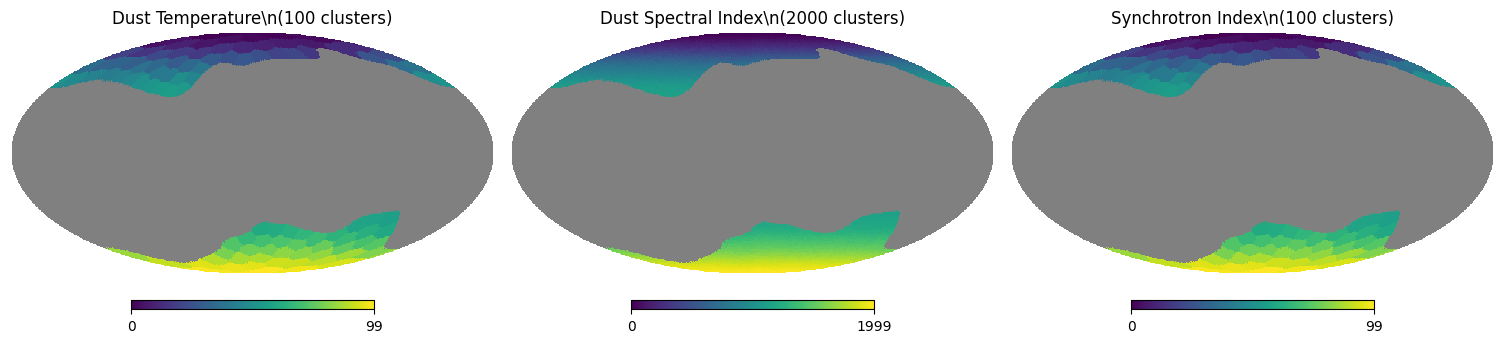

Masked clusters ready for optimization


In [ ]:
# Spherical K-means Clustering

# Configure clustering parameters for different spectral indices
cluster_config = {
    "temp_dust": 100,  # Dust temperature clusters
    "beta_dust": 2000,  # Dust spectral index clusters
    "beta_pl": 100,  # Synchrotron spectral index clusters
}

max_centroids = 2000  # Maximum cluster centers for algorithm

# Generate clusters for each parameter type
print("Generating spherical K-means clusters...")
clusters = {}

for param_name, cluster_count in cluster_config.items():
    print(f"  {param_name}: {cluster_count} clusters")

    # Generate spherical K-means clusters on unmasked pixels
    cluster_map = find_kmeans_clusters(
        mask,
        indices,
        cluster_count,
        jax.random.PRNGKey(42),  # Fixed seed for reproducibility
        max_centroids=max_centroids,
    )

    # Normalize cluster indices for consistent indexing
    cluster_map = normalize_by_first_occurrence(cluster_map, cluster_count, max_centroids)

    clusters[f"{param_name}_patches"] = cluster_map

print("Clustering complete!")

# Visualize the clustering results
fig = plt.figure(figsize=(15, 5))

param_labels = ["Dust Temperature", "Dust Spectral Index", "Synchrotron Index"]
for i, (param, label) in enumerate(zip(cluster_config.keys(), param_labels)):
    cluster_data = clusters[f"{param}_patches"]
    n_unique = jnp.unique(cluster_data[cluster_data != hp.UNSEEN]).size

    hp.mollview(
        cluster_data,
        title=f"{label}\\n({n_unique} clusters)",
        sub=(1, 3, i + 1),
        bgcolor=(0.0,) * 4,
    )

plt.tight_layout()
plt.show()

# Extract masked clusters for optimization
masked_clusters = get_cutout_from_mask(clusters, indices)
masked_clusters = jax.tree.map(lambda x: x.astype(jnp.int64), masked_clusters)
print("Masked clusters ready for optimization")

In [ ]:
# Parameter Optimization

# Setup optimization parameters
dust_nu0 = 150.0  # Dust reference frequency (GHz)
synchrotron_nu0 = 20.0  # Synchrotron reference frequency (GHz)

# Create objective function with fixed reference frequencies
negative_log_likelihood_fn = partial(
    negative_log_likelihood, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0
)

sky_signal_fn = partial(sky_signal, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0)

# Initialize parameters for each cluster (realistic starting values)
initial_params = {
    "temp_dust": jnp.full((cluster_config["temp_dust"],), 20.0),  # 20K dust temperature
    "beta_dust": jnp.full((cluster_config["beta_dust"],), 1.54),  # Dust spectral index
    "beta_pl": jnp.full((cluster_config["beta_pl"],), -3.0),  # Synchrotron index
}

print("Parameter initialization:")
for param, values in initial_params.items():
    print(f"  {param}: {len(values)} clusters, initial value = {values[0]}")

# Create noise operator (simplified for demonstration)
N = HomothetyOperator(jnp.ones(1), _in_structure=masked_d.structure)

# Setup L-BFGS optimizer
solver = optax.lbfgs()

print("\\nRunning optimization...")
print("This may take a few minutes...")

# Progress bar setup
progress_columns = [
    "[progress.description]{task.description}",
    BarColumn(),
    "[progress.percentage]{task.percentage:>3.0f}%",
    TimeElapsedColumn(),
    TimeRemainingColumn(),
]

# Run optimization with progress bar
with ProgressBar(*progress_columns) as p:
    final_params, final_state = optimize(
        initial_params,
        negative_log_likelihood_fn,
        solver,
        max_iter=100,  # Reduced for demo
        tol=1e-6,
        progress=p,
        nu=nu,
        N=N,
        d=masked_d,
        patch_indices=masked_clusters,
    )

# Show optimization results
print("\\nOptimization completed!")
print(f"Iterations: {final_state.count}")
print(f"Final function value: {final_state.value:.2e}")

# Display optimized parameter statistics
print("\\nOptimized parameter ranges:")
for param, values in final_params.items():
    print(
        f"  {param}: [{jnp.min(values):.3f}, {jnp.max(values):.3f}], "
        f"mean = {jnp.mean(values):.3f} ± {jnp.std(values):.3f}"
    )

# Compute CMB reconstruction with optimized parameters
reconstructed_signal = sky_signal_fn(
    final_params, nu=nu, d=masked_d, N=N, patch_indices=masked_clusters
)
cmb_reconstruction = reconstructed_signal["cmb"]
print("\\nCMB reconstruction completed")
print(f"CMB shape: Q={cmb_reconstruction.q.shape}, U={cmb_reconstruction.u.shape}")

Output()

Parameter initialization:
  temp_dust: 100 clusters, initial value = 20.0
  beta_dust: 2000 clusters, initial value = 1.54
  beta_pl: 100 clusters, initial value = -3.0
\nRunning optimization...
This may take a few minutes...


\nOptimization completed!
Iterations: <built-in method count of OptimizerState object at 0x718cec8dd070>
Final function value: -2.02e+07
\nOptimized parameter ranges:
  beta_dust: [1.345, 1.775], mean = 1.632 ± 0.041
  beta_pl: [-3.136, -2.901], mean = -3.019 ± 0.047
  temp_dust: [19.231, 20.923], mean = 20.114 ± 0.205
\nCMB reconstruction completed
CMB shape: Q=(9695,), U=(9695,)


In [ ]:
# Parameter Map Reconstruction

# Map cluster parameters back to full sky maps
print("Reconstructing full-sky parameter maps...")

param_maps = {}
for param_name in ["temp_dust", "beta_dust", "beta_pl"]:
    # Get optimized parameter values for each cluster
    param_values = final_params[param_name]
    cluster_indices = masked_clusters[f"{param_name}_patches"]

    # Map parameter values to masked pixels using cluster assignments
    param_map_masked = param_values[cluster_indices]

    # Convert back to full HEALPix map
    full_param_map = get_fullmap_from_cutout(param_map_masked, indices, nside=nside)
    param_maps[param_name] = full_param_map

print("Parameter map reconstruction completed!")

# Also reconstruct CMB maps for visualization
cmb_q_full = get_fullmap_from_cutout(cmb_reconstruction.q, indices, nside=nside)
cmb_u_full = get_fullmap_from_cutout(cmb_reconstruction.u, indices, nside=nside)

print("CMB maps reconstructed to full sky")
print(f"Parameter maps available: {list(param_maps.keys())}")

# Display parameter statistics
print("\\nFull-sky parameter statistics:")
for param_name, param_map in param_maps.items():
    valid_data = param_map[param_map != hp.UNSEEN]
    if len(valid_data) > 0:
        print(
            f"  {param_name}: [{jnp.min(valid_data):.3f}, {jnp.max(valid_data):.3f}], "
            f"mean = {jnp.mean(valid_data):.3f} ± {jnp.std(valid_data):.3f}"
        )
    else:
        print(f"  {param_name}: No valid data")

Reconstructing full-sky parameter maps...
Parameter map reconstruction completed!
CMB maps reconstructed to full sky
Parameter maps available: ['temp_dust', 'beta_dust', 'beta_pl']
\nFull-sky parameter statistics:
  temp_dust: [19.231, 20.923], mean = 20.115 ± 0.209
  beta_dust: [1.345, 1.775], mean = 1.632 ± 0.040
  beta_pl: [-3.136, -2.901], mean = -3.017 ± 0.047


/tmp/ipykernel_54759/1189568572.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


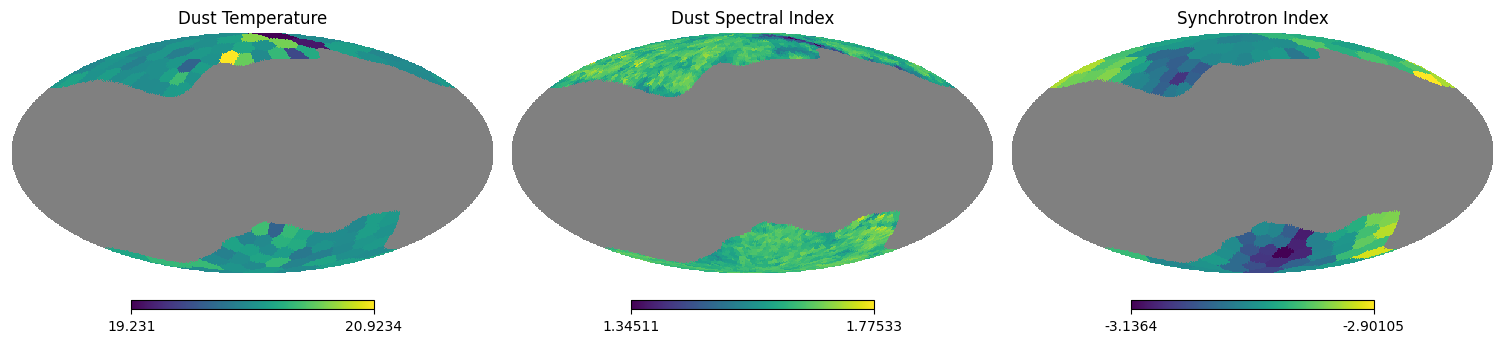

In [ ]:
# Results Visualization
fig = plt.figure(figsize=(15, 5))

# Plot the three parameter maps only
hp.mollview(param_maps["temp_dust"], title="Dust Temperature", sub=(1, 3, 1), bgcolor=(0.0,) * 4)

hp.mollview(param_maps["beta_dust"], title="Dust Spectral Index", sub=(1, 3, 2), bgcolor=(0.0,) * 4)

hp.mollview(param_maps["beta_pl"], title="Synchrotron Index", sub=(1, 3, 3), bgcolor=(0.0,) * 4)

plt.tight_layout()
plt.show()

## Command-Line Tool for Large-Scale Analysis

The complete workflow demonstrated above is implemented in the production script for large-scale analysis on HPC clusters.

### Basic Usage

```bash
# Run adaptive K-means clustering
kmeans-model -n 64 -pc 1000 50 10 -tag c1d1s1 -m GAL020 -i LiteBIRD
```

### Key Parameters

- `-n 64`: HEALPix resolution (nside=64 → ~55 arcmin pixels)
- `-pc 1000 50 10`: Cluster counts for [dust_beta, dust_temp, sync_beta]
- `-tag c1d1s1`: Sky simulation (CMB + dust + synchrotron)
- `-m GAL020`: Galactic mask (20% cleanest sky)
- `-i LiteBIRD`: Instrument configuration
- `-mi 1000`: Maximum optimizer iterations (optional, default: 1000)

### Output Structure

Results are saved to `results/kmeans_{config}/`:
- `best_params.npz`: Optimized spectral parameters per cluster
- `results.npz`: Full clustering and optimization results  
- `mask.npy`: Sky mask used for analysis

### Scaling to Large Problems

The command-line tool provides:
- **Distributed computing**: SLURM integration for GPU clusters
- **Monte Carlo analysis**: Multiple noise realizations (`-ns` parameter)
- **Parameter bounds**: Physical constraints on spectral parameters
- **Grid search**: Systematic exploration of cluster configurations
- **Variance-based selection**: Automatic optimal cluster determination

## Key Benefits

1. **Spatial Adaptivity**: Parameters vary across the sky to match astrophysical reality
2. **Variance Minimization**: Optimizes CMB reconstruction quality directly  
3. **Scalable Implementation**: JAX enables GPU acceleration and distributed computing
4. **Physical Constraints**: Realistic parameter bounds ensure meaningful results

This adaptive clustering approach provides significant improvements over uniform parameter methods, particularly for constraining the tensor-to-scalar ratio r in CMB B-mode analysis.